# Lab 7: Runing large-scale geospatial processing using an Amazon SageMaker AI processing jobs with a custom container image

This notebook is based on the [notebook](https://github.com/aws-samples/sagemaker-custom-image-for-geospatial-analytics/blob/main/notebooks/02-geospatial-processing-custom-image.ipynb) from the [Custom Geospatial SageMaker Image based on Amazon SageMaker Distribution](https://github.com/aws-samples/sagemaker-custom-image-for-geospatial-analytics) GitHub repository and was redesigned, extended, and adapted for SageMaker Pipelines.

<div class="alert alert-info"><b>Prerequsites:</b> You need to build and attach a custom SageMaker image by executing the <code>custom-sm-image/build_sm_custom_image.ipynb</code> notebook.<br/>After you executed the image build notebook and attach the custom image to the domain, open the current Lab 7 notebook in <b>a new JupyterLab app</b> and make sure to select the custom image you built and attached.
</div>

![](img/select-custom-image.png)

## What is in this notebook

This notebook demonstrates how to use SageMaker processing jobs to run geospatial workloads on a distributed remote cluster. It also shows usage of SageMaker pipelines to orchestrate workflow steps, such as data preparation, downloading, and processing.

## SageMaker containers and processing jobs

SageMaker makes use of Docker containers to enable developers to process and analyse data, train and deploy models. Containers allow to package software into standardized environments that run consistently on any platform that supports Docker. Containers ensure that code, runtime, system tools, system libraries, and settings are all in the same place, isolating them from the execution environment. It guarantees a consistent runtime experience regardless of where a container is being run.

SageMaker also provides pre-build containers with popular data processing frameworks and ML algorithms. All SageMaker built-in algorithms are delivered as Docker containers. You can also bring your own containers (BYOC) for any SageMaker processing or training job. 

In the notebook [`build_sm_custom_image`](./custom-sm-image/build_sm_custom_image.ipynb) you created a custom SageMaker image with geospatial packages. Now you can use this Docker image for SageMaker processing jobs.

To use [SageMaker Processing](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html) you provide a Python processing script and choose a [SageMaker SDK processor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html) class.

You must upload the input data to S3 and specify an S3 location for output data. SageMaker processing automatically loads the input data from S3 and uploads script output to S3 when the job is complete. The processing container image can either be an Amazon SageMaker built-in image or a custom image that you provide. SageMaker fully manages the underlying infrastructure for a processing job. Cluster resources are provisioned for the duration of your job, and cleaned up when a job completes.

![](img/sagemaker-processing.png)

This notebooks creates a typical geospatial processing routine and runs it on an automatically provisioned compute cluster. 
The processing script does raster file loading, AOI clipping, bands resampling, and cloud masking. 

The job processes 134 110x110km Sentinel-2 scenes in parallel and completes in under 20 minutes on 20 `ml.m5.2xlarge` instances.

Below is the CPU utilization of cluster instances for the processing job:
![](img/cluster-cpu-utilization.png)

## Import packages

If you use a custom SageMaker image to run this notebook kernel, you don't need to install packages because they are integrated in the custom image.

In [1]:
# geo libraries
import geopandas as gpd
import pandas as pd
import pystac_client
import shapely
from shapely import geometry, wkt
import leafmap
import rasterio
from rasterio.plot import show
import rioxarray

# other libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import json
from datetime import datetime, date
from time import gmtime, strftime, sleep
import boto3
from urllib.parse import urlparse
from IPython.display import JSON, HTML
from tqdm.notebook import trange, tqdm

# sagemaker SDK
import sagemaker
from sagemaker import utils
from sagemaker.sklearn.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Setup environment

In [2]:
# create a directory to keep scripts
!mkdir -p ./pipeline_steps
# create a directory for local data
!mkdir -p ./data

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# create sessions and clients
session = boto3.Session()
sagemaker_session = sagemaker.Session()
sm_role = sagemaker.get_execution_role()
region = sagemaker.Session().boto_region_name
s3_client = boto3.client('s3')
sm_client = boto3.client('sagemaker')

<div class="alert alert-info">Set the <code>geospatial_image_uri</code> in the following cell to the URI of the custom SageMaker image you created in the <code>build_sm_custom_image</code> notebook.
</div>

In [5]:
# set to uri of the geospatial image you have created
geospatial_image_uri = "906545278380.dkr.ecr.us-east-1.amazonaws.com/smd-custom-geo:1.11-cpu" 

In [6]:
timestamp = strftime('%d-%H-%M-%S', gmtime())
base_job_name = 'aoi-data-cube'
pipeline_name = f'aoi-data-cube-pipeline-{timestamp}'

In [7]:
# get domain_id, user profile name, and space_name from the metadata and space configuration
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        metadata = json.loads(f.read())
        domain_id = metadata.get('DomainId')
        space_name = metadata.get('SpaceName')
        print(f"SageMaker domain id: {domain_id}")

if not space_name:
    raise Exception(f"Cannot find the current space name. Make sure you run this notebook in a JupyterLab in the SageMaker Studio")
else:
    print(f"Space name: {space_name}")
    
r = sm_client.describe_space(DomainId=domain_id, SpaceName=space_name)
user_profile_name = r['OwnershipSettings']['OwnerUserProfileName']

assert(user_profile_name)
print(f"User profile: {user_profile_name}")

SageMaker domain id: d-f3jonv4qj6w1
Space name: geo-custom
User profile: studio-user-geo-697c4ae0


### Configure defaults of AWS infrastructure
Here you use a YAML configuration file to define the default values that are automatically passed to SageMaker APIs, for example as job parameters. It's especially convenient when you need to provide static parameters for infrastructure settings, such as VPC ids, Security Groups, KMS keys etc, or work with remote functions.

Refer to [Configuring and using defaults with the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk) documentation for examples and more details.

Your data processing pipeline uses these `config.yaml` file for the default configuration values.

In [8]:
%%writefile config.yaml
SchemaVersion: '1.0'
SageMaker:
    PythonSDK:
        Modules:
            RemoteFunction:
                IncludeLocalWorkDir: true
                CustomFileFilter:
                    IgnoreNamePatterns: # files or directories to ignore
                        - "*.ipynb" 
                        - "*.md" 
                        - "*.txt"
                        - "__pycache__"
                        - "*.zip"
                        - "*.gz"
                        - "*templates"
                        - "*image"
                        - "*img"
                        - "*data"
                        - "*output"

Overwriting config.yaml


In [9]:
# point SageMaker to the configuration file
os.environ["SAGEMAKER_USER_CONFIG_OVERRIDE"] = os.getcwd()

## Define an exemplary AOI

In [10]:
aoi_coords = [[-102.00723310488662,40.596123257503024],[-102.00723310488662,40.58168585757733],[-101.9882214495914,40.58168585757733],[-101.9882214495914,40.596123257503024],[-102.00723310488662,40.596123257503024]]
aoi_polygon = shapely.Polygon(aoi_coords)
aoi_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[aoi_polygon])

## Visualize the AOI

In [ ]:
Map = leafmap.Map(center=[40.596123257503024, -102.00723310488662], zoom=13)
Map.add_basemap("USGS NAIP Imagery")
Map.add_gdf(aoi_gdf, layer_name="test", style={"color": "yellow", "fillOpacity": 0.3, "clickable": True,})
Map

## Define temporal range

In [13]:
analysis_start_date = pd.to_datetime("2023-01-01T00:00:00Z").date()
analysis_end_date = pd.to_datetime("2023-12-31T23:59:59Z").date()

## Define type and number of processing instances

Using processing instances type, retrieve the maximum number of the processing instances allowed in the account quota. If you use your own AWS account, make sure you have sufficient quota for the specific instance type. We recommend to use 20 instances of type `ml.m5.2xlarge` or `ml.m5.4xlarge`. 
If you use an AWS workshop provisioned account, your quota number is about 4 instances. You cannot increase this quota for the AWS workshop account.

In [14]:
# define quota map for the max number of SageMaker processing jobs for a specific instance
processing_instance_quota_codes = {
    'ml.m5.2xlarge':'L-1D84B9D2',
    'ml.m5.4xlarge':'L-379E85A3',
}

In [16]:
# helper to check resource quota in the account
def check_quota(q_map, instance):
    quotas_client = boto3.client("service-quotas")

    r = quotas_client.get_service_quota(
        ServiceCode="sagemaker",
        QuotaCode=processing_instance_quota_codes[instance],
    )

    q = r["Quota"]["Value"]
    n = r["Quota"]["QuotaName"]

    if q < 1:
        raise Exception(f"Quota {q} for {n} < min required 1 instance. Select other instance type or increase quota")
   
    return int(q)

In [17]:
processing_instance_type = 'ml.m5.2xlarge'
check_quota(processing_instance_quota_codes, processing_instance_type)

20

In [18]:
# set type and number of processing instances in the cluster
processing_instance_count = min(check_quota(processing_instance_quota_codes, processing_instance_type), 20)

In [19]:
print(f'The processing job is going to create a cluster of {processing_instance_count} instances of type {processing_instance_type}')

The processing job is going to create a cluster of 20 instances of type ml.m5.2xlarge


## Define S3 bucket and prefix for storing data

In [20]:
s3_bucket_name = sagemaker_session.default_bucket()
s3_prefix = 'processing/geospatial-data-cube'
s3_url = f's3://{s3_bucket_name}/{s3_prefix}'

## Create a data processing pipeline

You create a simple two-step pipeline with the first step for data downloading from AWS Open Data and the second step with data processing using a distributed cluster:
| Step | Description |
|---|---|
| **Data preparation** | runs a SageMaker processing job to search Sentinel-2 data, download AOI and image metadata, and to upload data to S3 for further processing|
| **Data processing** | runs a distributed SageMaker processing job for geospatial data processing|

To facilitate implementation of your pipeline as code you're going to use the `@step` decorator.

In [21]:
# import sagemaker modules required for pipeline operations
from sagemaker.workflow.parameters import ParameterString, ParameterInteger
from sagemaker.workflow.execution_variables import ExecutionVariables
from sagemaker.workflow.function_step import step
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import ProcessingStep, CacheConfig
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig 
from sagemaker.workflow.functions import Join

[SageMaker Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines.html) supports [parameterization](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html), which allows you to specify input parameters at runtime without changing your pipeline code. You can use the parameter classes available under the [`sagemaker.workflow.parameters`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#parameters) module.
Parameters have a default value, which you can override by specifying parameter values when starting a pipeline execution.

In [22]:
# define pipeline parameters
pipeline_parameters = {
    'analysis_start_date':
    # Analysis start date, serialized to string
    ParameterString(
        name="AnalysisStartDate",
        default_value=analysis_start_date.isoformat(),
    ),
    'analysis_end_date':
    # Analysis end date, serialized to string
    ParameterString(
        name="AnalysisEndDate",
        default_value=analysis_end_date.isoformat(),
    ),
    'aoi_coords':
    # AOI coordinates, serialized to string
    ParameterString(
        name="AOICoords",
        default_value=json.dumps(aoi_coords),
    ),
    'processing_instance_type':
    # Processing instance type
    ParameterString(
        name="ProcessingInstanceType",
        default_value=processing_instance_type,
    ),
    'processing_instance_count':
    # Number of processing instances in the cluster
    ParameterInteger(
        name="ProcessingInstanceCount",
        default_value=processing_instance_count,
    ),
    'processing_image_uri':
    # ECR URI of the custom processing imager
    ParameterString(
        name="ProcessingImageURI",
        default_value=geospatial_image_uri,
    ),
    's3_output_url':
    # S3 url for storing data
    ParameterString(
        name="S3OutputUrl",
        default_value=s3_url,
    ),
}

### Create the data preparation step

In this section you create and test the first step of the pipeline.

#### @step decorator
You can lift-and-shift your existing Python code to SageMaker pipelines. You can use Python functions to implement a processing workflow using geospatial libraries and test all code locally in the notebook. When you want to create a pipeline, you can use the SageMaker Python SDK [`@step`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#step-decorator) decorator to convert Python functions into pipeline steps. Refer to the SageMaker [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-create-pipeline.html) for more details and examples.

This notebook uses a Python function to implement the data preparation step, tests it locally, and then applies `@step` decorator to use the function as a pipeline step.

#### Limitations with @step decorator
Be aware of the specific [limitations](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-step-decorator-limit.html) when you use `@step` decorator for pipeline steps.

Create a data preparation script as a Python function:

In [23]:
%%writefile ./pipeline_steps/prepare_data.py
import geopandas as gpd
import pandas as pd
import pystac_client
import shapely
from shapely import geometry, wkt

import boto3
import numpy as np
import pandas as pd
import json
from sagemaker import utils
from datetime import datetime, date
from urllib.parse import urlparse

# helpers
def _parse_s3_url(s3_url):
    parsed = urlparse(s3_url)
    return parsed.netloc, parsed.path.lstrip('/')
    
def _generate_execution_id():
    return utils.unique_name_from_base(datetime.now().strftime('%Y%m%d_%H%M%S'))
    
def _search_sentinel2_collection(
    start_date, 
    end_date, 
    aoi_geometry, 
    max_cloud=100
):
    """
    Search Sentinel 2 data collection for target_date
    and collect results including meta data in a dictionary.
    This function uses the PySTAC client
    """
    client = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
    collection = "sentinel-2-l2a"
    
    search = client.search(
        collections=[collection],
        query = {"eo:cloud_cover":{"lt":max_cloud}},
        intersects=aoi_geometry.to_crs("EPSG:4326").geometry[0].__geo_interface__, 
        datetime=f"{start_date}/{end_date}"
    )
    
    s2_items = []
    for item in search.items_as_dicts():
        s2_items.append(item)
        
    return s2_items

# main data preparation script
def prepare_data(
    analysis_start_date:str, 
    analysis_end_date:str, 
    aoi_coords:str,
    output_s3_url:str,
    pipeline_execution_id:str = None,
):

    print('Starting data preparation')
    aoi_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[shapely.Polygon(json.loads(aoi_coords))])

    print(f'''
    Input parameters:
    Polygon: {aoi_gdf.to_dict()}
    Start date: {analysis_start_date}
    End date: {analysis_end_date}
    ''')

    print('Starting Sentinel-2 search')
    # this call DOES NOT download all find tiles, it creates a dictionary of tile metadata
    sentinel2_items = _search_sentinel2_collection(
        start_date=date.fromisoformat(analysis_start_date),
        end_date=date.fromisoformat(analysis_end_date),
        aoi_geometry = aoi_gdf.geometry,
    )

    print("Total Sentinel-2 items found:", len(sentinel2_items))

    # set S3 prefixes for data upload
    execution_id = pipeline_execution_id if pipeline_execution_id else _generate_execution_id()

    s3_url_scenes_meta = f"{output_s3_url}/{execution_id}/input/sentinel2_scenes"
    s3_url_aoi_meta = f"{output_s3_url}/{execution_id}/input/aoi"

    # load the metadata into a DataFrame
    s2_search_results = pd.DataFrame(sentinel2_items)
    s2_search_results
    
    # review tile ids and their prevalence
    s2_search_results["tile_id"] = s2_search_results["id"].apply(lambda x: x.split("_")[1])
    s2_search_results.groupby(["tile_id"]).count()["id"]
    
    # limit to one tile ID only
    tile_id = "13TGE"
    manifest_file = [i for i in sentinel2_items if tile_id in i["id"]]
    print('Scenes in scope:', len(manifest_file))

    s3_client = boto3.client('s3')
    bucket_name, prefix_scenes_meta = _parse_s3_url(s3_url_scenes_meta)
    _, prefix_aoi_meta = _parse_s3_url(s3_url_aoi_meta)
    
    # upload metadata files to S3
    print(f'Uploading {len(manifest_file)} metadata files for the tile {tile_id} to {s3_url_scenes_meta}')
    for s in manifest_file:
        s3_client.put_object(
            Body=(bytes(json.dumps(s, default=str).encode('UTF-8'))),
            Bucket=bucket_name, 
            Key=f'{prefix_scenes_meta}/{s["id"]}_metadata.json'
        )

    # upload aoi metadata to S3
    aoi_dict = {
        'name':'us_field',
        'coords':json.loads(aoi_coords),
        'crs':'epsg:4326'
    }
    
    file_name_aoi = "aoi_metadata.json"
    print(f'Uploading AOI metadata to {s3_url_aoi_meta}')
    response = s3_client.put_object(
        Body=(bytes(json.dumps(aoi_dict, default=str).encode('UTF-8'))),
        Bucket=bucket_name, Key=f'{prefix_aoi_meta}/{file_name_aoi}')

    return {
        'tile_id':tile_id,
        'scene_count':len(manifest_file),
        's3_url_scenes_meta':s3_url_scenes_meta,
        's3_url_aoi_meta':s3_url_aoi_meta,
    }

Overwriting ./pipeline_steps/prepare_data.py


In [24]:
# Import the Python function from the the local module
from pipeline_steps.prepare_data import prepare_data

Now run your Python function locally in the notebook and verify the corectness of your code before constructing a pipeline:

In [25]:
r_prepare = prepare_data(
    analysis_start_date=pipeline_parameters['analysis_start_date'].default_value, 
    analysis_end_date=pipeline_parameters['analysis_end_date'].default_value, 
    aoi_coords=pipeline_parameters['aoi_coords'].default_value,
    output_s3_url=pipeline_parameters['s3_output_url'].default_value,
)
r_prepare

Starting data preparation

    Input parameters:
    Polygon: {'geometry': {0: <POLYGON ((-102.007 40.596, -102.007 40.582, -101.988 40.582, -101.988 40.59...>}}
    Start date: 2023-01-01
    End date: 2023-12-31
    
Starting Sentinel-2 search
Total Sentinel-2 items found: 531
Scenes in scope: 134
Uploading 134 metadata files for the tile 13TGE to s3://sagemaker-us-east-1-906545278380/processing/geospatial-data-cube/20250209_173237-1739122357-4cc5/input/sentinel2_scenes
Uploading AOI metadata to s3://sagemaker-us-east-1-906545278380/processing/geospatial-data-cube/20250209_173237-1739122357-4cc5/input/aoi


{'tile_id': '13TGE',
 'scene_count': 134,
 's3_url_scenes_meta': 's3://sagemaker-us-east-1-906545278380/processing/geospatial-data-cube/20250209_173237-1739122357-4cc5/input/sentinel2_scenes',
 's3_url_aoi_meta': 's3://sagemaker-us-east-1-906545278380/processing/geospatial-data-cube/20250209_173237-1739122357-4cc5/input/aoi'}

In [ ]:
# verify that the function uploaded scene and AOI metadata files to specificed S3 url
!aws s3 ls {r_prepare['s3_url_scenes_meta']} --recursive

In [27]:
!aws s3 ls {r_prepare['s3_url_aoi_meta']} --recursive

2025-02-09 17:32:44        263 processing/geospatial-data-cube/20250209_173237-1739122357-4cc5/input/aoi/aoi_metadata.json


### Create the data processing step

In this section you develop a processing script that generates a data cube of different bands across the one year of observations for the AOI in scope.

For each Sentinel-2 scene the script does:
1. Load the required bands
2. Perform re-sampling to 10m resolution where required, for example for bands lower than 10m resolution
3. Merge all bands into a single xarray
4. Intersect the xarray with a given geometry
5. Filter out scenes with cloud cover above a certain threshold within the AOI (not the S2 tile)
6. Save the clipped xarray data cube as a NetCDF file

In [28]:
%%writefile ./pipeline_steps/generate_aoi_data_cube.py
import os
import pickle
import sys
import subprocess
import warnings
import json
import time
import geopandas
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import shape
from shapely.geometry import Polygon
import xarray as xr
import rioxarray
from rioxarray.exceptions import NoDataInBounds
import gc
import logging
import datetime

# Parameters
MAX_CLOUD_COVER_AOI = 0.3 # maximum 30% cloud coverage WTHIN area of interest (not the full tile)

# HELPERS
def get_logger(log_level):    
    logger = logging.getLogger("processing")

    console_handler = logging.StreamHandler(sys.stdout)
    # include %(name)s to also include logger name
    console_handler.setFormatter(logging.Formatter('%(asctime)s [%(levelname)s] %(message)s'))
    console_handler.setLevel(log_level)

    logger.addHandler(console_handler)
    logger.setLevel(log_level)
    return logger

def s2_scene_id_to_cog_path(scene_id):
    parts = scene_id.split("_")
    s2_qualifier = "{}/{}/{}/{}/{}/{}".format(
        parts[1][0:2],
        parts[1][2],
        parts[1][3:5],
        parts[2][0:4],
        str(int(parts[2][4:6])),
        "_".join(parts)
    )
    return f"https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/{s2_qualifier}/"

def scene_id_to_datetime(scene_id):
    dt = pd.to_datetime(scene_id.split("_")[-3])
    return dt

def get_aoi_cloud_free_ratio(SCL_raster, aoi_gdf):
    # reproject to EPSG:4326
    kwargs = {"nodata": np.nan}
    SCL_raster = SCL_raster.rio.reproject("EPSG:4326", **kwargs)
    
    # clip to AOI
    SCL_raster_clipped = SCL.rio.clip(aoi_gdf.geometry.values, aoi_gdf.crs, drop=False, invert=True)
    
    # get cloud-free ratio
    # get size of SCL mask in num pixels (excl. any nans)
    SCL_mask_pixel_count = SCL_raster_clipped.SCL.data.size - np.count_nonzero(np.isnan(SCL_raster_clipped.SCL.data)) 
    
    # see here: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/
    SCL_classes_cloud_free = [4,5,6] 

    # count pixels that are non-cloud class
    SCL_cloud_free_pixel_count = np.isin(SCL_raster_clipped.SCL.data,SCL_classes_cloud_free).sum() 
    cloud_free_ratio = SCL_cloud_free_pixel_count/SCL_mask_pixel_count
    
    return cloud_free_ratio

# main
if __name__ == "__main__":
    logger = get_logger(logging.DEBUG) #INFO
    
    logger.info("Starting processing")
    logger.debug(f"Argument List: {str(sys.argv)}")

    # set permissions on output path
    output_path = "/opt/ml/processing/output/"
    subprocess.check_call(["sudo","chown","-R","sagemaker-user", output_path])
    
    # load geometry and construct gdf
    aoi_path = '/opt/ml/processing/input/aoi_meta/aoi_metadata.json'
    with open(aoi_path) as file:
        aoi_metadata = json.load(file)
    polygon = Polygon(aoi_metadata["coords"])
    aoi_gdf = gpd.GeoDataFrame(index=[0], crs=aoi_metadata["crs"], geometry=[polygon])
                
    # load all the sentinel-2 metadata files
    s2_data_path = '/opt/ml/processing/input/sentinel2_meta/'
    s2_items = []
    for current_path, sub_dirs, files in os.walk(s2_data_path):
        for file in files:
            if file.endswith(".json"):
                full_file_path = os.path.join(s2_data_path, current_path, file)
                with open(full_file_path, 'r') as f:
                    s2_items.append(json.load(f))
    
    item_count_total = len(s2_items)
    item_count_current = 0
    elapsed_time_batch = 0
    logger.info("Received {} scenes to process".format(item_count_total))

    for item in s2_items:        
        if item_count_current > 0 and item_count_current % 5 == 0:
            logger.info("Processed {}/{} scenes ({}s per scene)".format(
                item_count_current, 
                item_count_total,
                round(elapsed_time_batch / item_count_current, 2)
            ))
        item_count_current += 1

        start = time.time()
        s2_scene_id = item["id"]
        logger.debug("Processing scene: {}".format(s2_scene_id))
        
        s2_cog_prefix = s2_scene_id_to_cog_path(s2_scene_id)
        grid_id = s2_scene_id.split("_")[1]
        
        # time/date
        date = scene_id_to_datetime(s2_scene_id)
        
        # 10m bands
        blue_band_url = f"{s2_cog_prefix}/B02.tif"
        green_band_url = f"{s2_cog_prefix}/B03.tif"
        red_band_url = f"{s2_cog_prefix}/B04.tif"
        nir1_band_url = f"{s2_cog_prefix}/B08.tif"
        
        #20m bands
        nir2_band_url = f"{s2_cog_prefix}/B8A.tif"
        swir1_band_url = f"{s2_cog_prefix}/B11.tif"
        swir2_band_url = f"{s2_cog_prefix}/B12.tif"
        scl_mask_url = f"{s2_cog_prefix}/SCL.tif"
        
        # read from S3
        
        # 10m bands
        B02 = rioxarray.open_rasterio(blue_band_url, masked=True,band_as_variable=True)
        B02 = B02.rename(name_dict={"band_1":"B02"})
        B03 = rioxarray.open_rasterio(green_band_url, masked=True,band_as_variable=True)
        B03 = B03.rename(name_dict={"band_1":"B03"})
        B04 = rioxarray.open_rasterio(red_band_url, masked=True,band_as_variable=True)
        B04 = B04.rename(name_dict={"band_1":"B04"})
        B08 = rioxarray.open_rasterio(nir1_band_url, masked=True,band_as_variable=True)
        B08 = B08.rename(name_dict={"band_1":"B08"})
        
        # 20m bands/masks
        B8A = rioxarray.open_rasterio(nir2_band_url, masked=True,band_as_variable=True)
        B8A = B8A.rename(name_dict={"band_1":"B8A"})
        B11 = rioxarray.open_rasterio(swir1_band_url, masked=True,band_as_variable=True)
        B11 = B11.rename(name_dict={"band_1":"B11"})
        B12 = rioxarray.open_rasterio(swir2_band_url, masked=True,band_as_variable=True)
        B12 = B12.rename(name_dict={"band_1":"B12"})
        SCL = rioxarray.open_rasterio(scl_mask_url, masked=True,band_as_variable=True)
        SCL = SCL.rename(name_dict={"band_1":"SCL"})
        
        # resample to 10m where needed (relatively compute intensive!)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            B8A = B8A.interp(x=B02["x"], y=B02["y"])
            B11 = B11.interp(x=B02["x"], y=B02["y"])
            B12 = B12.interp(x=B02["x"], y=B02["y"])
            SCL = SCL.interp(x=B02["x"], y=B02["y"])

        # merge bands
        band_arrays = [B02,B03,B04,B08,B8A,B11,B12,SCL]
        s2_cube=xr.merge(objects=band_arrays)
        del B02
        del B03
        del B04
        del B08
        del B8A
        del B11
        del B12
        del band_arrays
        gc.collect()
        
        # assign time dimension
        s2_cube = s2_cube.assign_coords(time=date) #call this 'time'
        # reproject to EPSG:4326
        kwargs = {"nodata": np.nan}
        s2_cube = s2_cube.rio.reproject("EPSG:4326", **kwargs) 
        
        # check cloud-free ratio at aoi level
        cloud_free_ratio = get_aoi_cloud_free_ratio(SCL_raster=SCL, aoi_gdf=aoi_gdf)
        if (1-float(cloud_free_ratio)) > MAX_CLOUD_COVER_AOI: #skip if too cloudy for given geom
            logger.debug(f"AOI cloud cover ratio too high ({round(1-cloud_free_ratio,3)}), skipping scene {s2_scene_id}...")
            del cloud_free_ratio
        else: # continue if not too cloudy for given geom
            logger.debug(f"AOI cloud cover ratio below threshold ({round(1-cloud_free_ratio,3)}), processing scene {s2_scene_id}...")     
            try:
                clipped = s2_cube.rio.clip(aoi_gdf.geometry.values, aoi_gdf.crs)
            except NoDataInBounds as e:
                logger.warn("Skipping {}: no data in bounds".format(s2_scene_id))
                continue
                
            # save to file
            file_name = "{}-{}.nc".format(aoi_metadata["name"],s2_scene_id)
            output_file_path = f"{output_path}{file_name}"

            clipped.to_netcdf(output_file_path)

            logger.debug(f"Written output:{output_file_path}")

            del clipped
            del cloud_free_ratio
            gc.collect()
            
        # explicit dereference to keep memory usage low
        del s2_cube
        del SCL
        gc.collect()
        
        elapsed_time = time.time() - start
        elapsed_time_batch += elapsed_time
        
        logger.debug("Processed scene {}: {}s".format(s2_scene_id, elapsed_time))

Overwriting ./pipeline_steps/generate_aoi_data_cube.py


### Construct the pipeline

In this section you construct the processing pipeline with two steps.

Specially consider how the input for the SageMaker processing job - the second step - is configured in the next cell. You create two input channels as [`ProcessingInput`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ProcessingInput) objects:

1. A single geometry file of the AOI
2. One metadata file per selected Sentinel-2 scene. Seperating scenes into individual files makes sharding for distributed training easy using the `ShardedByS3Key` distribution strategy as described below

For distributed data processing you want SageMaker to replicate a subset of data on each compute instance that is launched for job processing. You need to set the parameter `s3_data_distribution_type` of the `ProcessingInput` object to `ShardedByS3Key`. If there are N compute instances launched for a processing job, each instance gets approximately 1/N of the number of S3 objects. In this case, processing script on each machine uses only the subset of the data. See the [SageMaker API reference](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_S3DataSource.html) and [SageMaker Python SDK documentation](s3_data_distribution_type) for details.

You don't need to manually define an ordering of the steps, as SageMaker automatically derives the processing flow based on data dependencies between pipeline's steps. You also don't need to manage transfer of artifacts and datasets from one pipeline's step to another, because SageMaker automatically takes care of the data flow.

In [29]:
# prepare data step
step_prepare_data = step(
    prepare_data, 
    name='prepare',
    image_uri=pipeline_parameters['processing_image_uri'],
    instance_type=pipeline_parameters['processing_instance_type'],
)(
    analysis_start_date=pipeline_parameters['analysis_start_date'], 
    analysis_end_date=pipeline_parameters['analysis_end_date'], 
    aoi_coords=pipeline_parameters['aoi_coords'],
    output_s3_url=pipeline_parameters['s3_output_url'],
    pipeline_execution_id=ExecutionVariables.PIPELINE_EXECUTION_ID
)

# configure inputs and outputs for the data processor
data_processing_inputs=[
    ProcessingInput(
        source=step_prepare_data['s3_url_aoi_meta'],
        destination='/opt/ml/processing/input/aoi_meta/',
        s3_data_distribution_type="FullyReplicated"
    ),        
    ProcessingInput(
        source=step_prepare_data['s3_url_scenes_meta'],
        destination='/opt/ml/processing/input/sentinel2_meta/',
        # set to ShardedByS3Key
        s3_data_distribution_type="ShardedByS3Key"
    ),
]

data_processing_outputs=[
    ProcessingOutput(
        source='/opt/ml/processing/output/',
        destination=Join(
            on='/',
            values=[pipeline_parameters['s3_output_url'], ExecutionVariables.PIPELINE_EXECUTION_ID, 'output/']
        )
    )
]

# data processing step
step_process_data = ProcessingStep(
    name='process',
    processor=ScriptProcessor(
        command=['python3'],
        image_uri=pipeline_parameters['processing_image_uri'],
        role=sm_role,
        instance_count=pipeline_parameters['processing_instance_count'], 
        instance_type=pipeline_parameters['processing_instance_type'],
        base_job_name=base_job_name,
    ),
    inputs=data_processing_inputs,
    outputs=data_processing_outputs,
    code='./pipeline_steps/generate_aoi_data_cube.py',
    cache_config=CacheConfig(enable_caching=True, expire_after='P30d'),
)

# create a pipeline object
pipeline = Pipeline(
    name=f"{pipeline_name}",
    parameters=[v for v in pipeline_parameters.values()],
    steps=[step_process_data],
    pipeline_definition_config=PipelineDefinitionConfig(use_custom_job_prefix=True)
)

sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/amazon-sagemaker-ai-for-geospatial


Upsert operation serialize the function code, arguments, and other artefacts to S3 where it can be accessed during pipeline's runtime:

In [30]:
# if a pipeline with the same name already exists, SageMaker updates it
pipeline.upsert(role_arn=sm_role)

sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.IncludeLocalWorkDir
sagemaker.config INFO - Applied value from config key = SageMaker.PythonSDK.Modules.RemoteFunction.CustomFileFilter.IgnoreNamePatterns


2025-02-09 17:33:02,640 sagemaker.remote_function INFO     Uploading serialized function code to s3://sagemaker-us-east-1-906545278380/aoi-data-cube-pipeline-09-17-30-58/prepare/2025-02-09-17-33-01-096/function
2025-02-09 17:33:02,693 sagemaker.remote_function INFO     Uploading serialized function arguments to s3://sagemaker-us-east-1-906545278380/aoi-data-cube-pipeline-09-17-30-58/prepare/2025-02-09-17-33-01-096/arguments
2025-02-09 17:33:02,927 sagemaker.remote_function INFO     Copied user workspace to '/tmp/tmpjeedzeoc/temp_workspace/sagemaker_remote_function_workspace'
2025-02-09 17:33:05,011 sagemaker.remote_function INFO     Successfully created workdir archive at '/tmp/tmpjeedzeoc/workspace.zip'
2025-02-09 17:33:05,681 sagemaker.remote_function INFO     Successfully uploaded workdir to 's3://sagemaker-us-east-1-906545278380/aoi-data-cube-pipeline-09-17-30-58/sm_rf_user_ws/2025-02-09-17-33-01-096/workspace.zip'


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/aoi-data-cube-pipeline-09-17-30-58',
 'ResponseMetadata': {'RequestId': 'a4570a0f-f1ec-4c24-829a-f98c20758091',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a4570a0f-f1ec-4c24-829a-f98c20758091',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '102',
   'date': 'Sun, 09 Feb 2025 17:33:06 GMT'},
  'RetryAttempts': 0}}

To see the created pipeline in the Studio UI, click on the link constructed by the code cell below:

In [31]:
# Show the pipeline link
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/pipelines/{}/graph">the pipeline graph</a> in the Studio UI</b>'.format(
            domain_id, region, pipeline_name))
)

Now you're ready to execute your data processing pipeline.

## Execute the pipeline


<div class="alert alert-info">A pipeline execution takes about <b>25 minutes</b> if you use 20 processing instances. If you're in an AWS-led workshop, you have four processing instances and the execution takes about <b>70 minutes</b>.
</div>

In [32]:
# this starts a pipeline execution
pipeline_execution = pipeline.start()
pipeline_execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/aoi-data-cube-pipeline-09-17-30-58',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:906545278380:pipeline/aoi-data-cube-pipeline-09-17-30-58/execution/ec9ytth1xv1a',
 'PipelineExecutionDisplayName': 'execution-1739122402814',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2025, 2, 9, 17, 33, 22, 754000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 2, 9, 17, 33, 22, 754000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profile/d-f3jonv4qj6w1/studio-user-geo-697c4ae0',
  'UserProfileName': 'studio-user-geo-697c4ae0',
  'DomainId': 'd-f3jonv4qj6w1',
  'IamIdentity': {'Arn': 'arn:aws:sts::906545278380:assumed-role/sm-domain-geo-SageMakerExecutionRole-zxtWn3ke8A0C/SageMaker',
   'PrincipalId': 'AROA5GESPFWWPRPZ3Z7X6:SageMaker'}},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:906545278380:user-profi

In [36]:
# Uncomment if you would like to wait in the notebook until this execution completes
# pipeline_execution.wait() 
pipeline_execution.list_steps()

[{'StepName': 'prepare',
  'StartTime': datetime.datetime(2025, 2, 9, 17, 33, 23, 848000, tzinfo=tzlocal()),
  'StepStatus': 'Executing',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:906545278380:training-job/prepare-data-ec9ytth1xv1a-MJtgDSmtyn'}},
  'AttemptCount': 1}]

You can see the pipeline execution in the Studio UI by clicking on the link constructed by the following code cell:

In [37]:
# Show the pipeline execution link
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/pipelines/{}/executions/{}/graph">the pipeline execution</a> in the Studio UI</b>'.format(
            domain_id, region, pipeline_name, pipeline_execution.describe()['PipelineExecutionArn'].split('/')[-1]))
)

## Explore pipeline execution results

After the pipeline execution completed, the data processing script stored the processed AOI data cube as a NetCDF file on the S3.

In [38]:
# make sure the execution completed
pipeline_execution.wait()
assert pipeline_execution.describe()['PipelineExecutionStatus'] == 'Succeeded'

In [39]:
pipeline_execution_id = pipeline_execution.arn.split('/')[-1]

In [40]:
# Display all steps with StepStatus
pipeline_execution.list_steps()

[{'StepName': 'process',
  'StartTime': datetime.datetime(2025, 2, 9, 17, 37, 8, 846000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 2, 9, 17, 57, 14, 190000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:906545278380:processing-job/process-af27a6affdaa2b3ee7b98b975eea952-ec9ytth1xv1a-30VDc3JVeV'}},
  'AttemptCount': 1},
 {'StepName': 'prepare',
  'StartTime': datetime.datetime(2025, 2, 9, 17, 33, 23, 848000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2025, 2, 9, 17, 37, 7, 955000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:906545278380:training-job/prepare-data-ec9ytth1xv1a-MJtgDSmtyn'}},
  'AttemptCount': 1}]

In [41]:
# get processing job name from the pipeline step properties
process_step = [s for s in pipeline_execution.list_steps() if s['StepName'] == 'process'][0]
processing_job_name = process_step['Metadata']['ProcessingJob']['Arn'].split('/')[-1]
job_descriptor = sm_client.describe_processing_job(ProcessingJobName=processing_job_name)

In [42]:
# get job details
job_duration = job_descriptor['ProcessingEndTime'] - job_descriptor['ProcessingStartTime']
job_output_s3_url = job_descriptor["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]

print(f'Processing job output located at {job_output_s3_url}')
print(f'Processing job {job_descriptor["ProcessingJobName"]} took {job_duration} to complete')

Processing job output located at s3://sagemaker-us-east-1-906545278380/processing/geospatial-data-cube/ec9ytth1xv1a/output/
Processing job process-af27a6affdaa2b3ee7b98b975eea952-ec9ytth1xv1a-30VDc3JVeV took 0:16:29 to complete


### Download processed scenes from S3

In [43]:
def _parse_s3_url(s3_url):
    parsed = urlparse(s3_url)
    return parsed.netloc, parsed.path.lstrip('/')

In [44]:
output_bucket_name, output_bucket_prefix = _parse_s3_url(job_output_s3_url)

files = s3_client.list_objects_v2(Bucket=output_bucket_name, Prefix=output_bucket_prefix).get('Contents', [])

In [45]:
# download each object to local the notebook EBS volume
print(f'Downloading {len(files)} processed files from {job_output_s3_url}')
local_directory = 'data'

for obj in tqdm(files, total=len(files), desc='Downloading files'):
    key = obj['Key']
    local_path = os.path.join(local_directory, key)

    # Create local directories if they don't exist
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    # Download the object
    s3_client.download_file(output_bucket_name, key, local_path)

### Process scenes
Now aggregate the downloaded scenes into a data cube with dimensions {time, x, y}.

In [46]:
# get individual time-stamped scenes
import xarray as xr
files = os.listdir(f"{local_directory}/{output_bucket_prefix}")
scenes = []
for f in tqdm(files, total=len(files), desc='Opening files in xarray'):
    scene = xr.open_dataset(f"{local_directory}/{output_bucket_prefix}{f}", decode_coords="all")
    scenes.append(scene)

# generate cube
s2_cube = xr.concat(objs=scenes, coords="minimal", dim="time",join='outer')
s2_cube = s2_cube.sortby("time")

Opening files in xarray:   0%|          | 0/48 [00:00<?, ?it/s]

In [47]:
s2_cube

<xarray.Dataset> Size: 79MB
Dimensions:      (time: 48, y: 139, x: 184)
Coordinates:
  * x            (x) float64 1kB -102.0 -102.0 -102.0 ... -102.0 -102.0 -102.0
  * y            (y) float64 1kB 40.6 40.6 40.6 40.6 ... 40.58 40.58 40.58 40.58
  * time         (time) datetime64[ns] 384B 2023-03-09 2023-04-03 ... 2023-12-16
    spatial_ref  int32 4B 0
Data variables:
    B02          (time, y, x) float64 10MB 1.556e+03 948.0 814.0 ... 791.0 952.0
    B03          (time, y, x) float64 10MB 2.056e+03 1.282e+03 ... 1.222e+03
    B04          (time, y, x) float64 10MB 1.946e+03 1.376e+03 ... 1.62e+03
    B08          (time, y, x) float64 10MB 2.342e+03 1.908e+03 ... 2.33e+03
    B8A          (time, y, x) float64 10MB 2.324e+03 2.179e+03 ... 2.376e+03
    B11          (time, y, x) float64 10MB 1.812e+03 1.778e+03 ... 3.361e+03
    B12          (time, y, x) float64 10MB 1.226e+03 1.209e+03 ... 2.829e+03
    SCL          (time, y, x) float64 10MB 11.0 11.0 11.0 11.0 ... 5.0 5.0 5.0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE

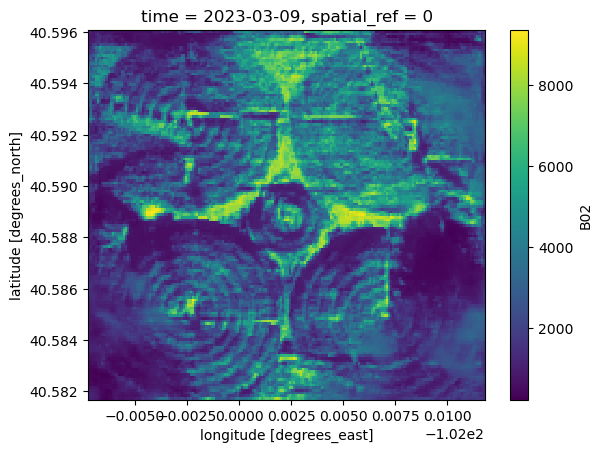

In [48]:
# get earliest observation and plot band B02
s2_cube.B02.sel(time=s2_cube.time.min()).plot()

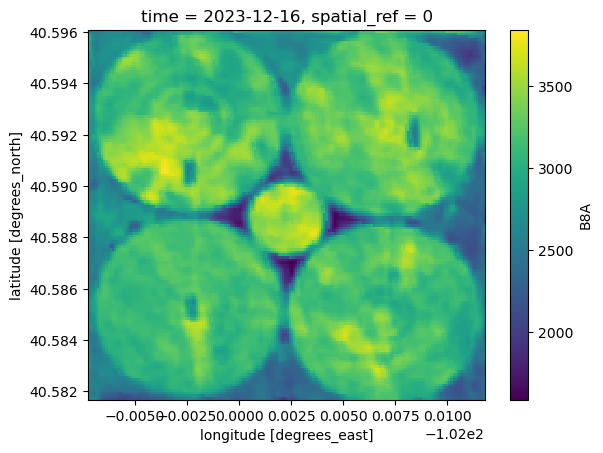

In [49]:
# get latest observation and plot band B8A
s2_cube.B8A.sel(time=s2_cube.time.max()).plot()

### Remove pixels with clouds

In [50]:
# only retain non-cloudy pixels using Sentinel scene classification: 
# https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/
s2_cube_clean = s2_cube.where(s2_cube.SCL.isin([4,5,7])) 

### Compute spectral indices 
Compute Normalized Difference Vegetation Index (NDVI) and Normalized Burn Ratio (NBR).

In [51]:
s2_cube_clean['NDVI'] = (s2_cube_clean.B08 - s2_cube_clean.B04) / (s2_cube_clean.B08 + s2_cube_clean.B04)
s2_cube_clean['NBR'] = (s2_cube_clean.B08 - s2_cube_clean.B12) / (s2_cube_clean.B08 + s2_cube_clean.B12) #NBR = (B8 - B12) / (B8 + B12)

In [52]:
s2_cube_clean

<xarray.Dataset> Size: 98MB
Dimensions:      (time: 48, y: 139, x: 184)
Coordinates:
  * x            (x) float64 1kB -102.0 -102.0 -102.0 ... -102.0 -102.0 -102.0
  * y            (y) float64 1kB 40.6 40.6 40.6 40.6 ... 40.58 40.58 40.58 40.58
  * time         (time) datetime64[ns] 384B 2023-03-09 2023-04-03 ... 2023-12-16
    spatial_ref  int32 4B 0
Data variables:
    B02          (time, y, x) float64 10MB nan nan nan nan ... 968.0 791.0 952.0
    B03          (time, y, x) float64 10MB nan nan nan ... 1.024e+03 1.222e+03
    B04          (time, y, x) float64 10MB nan nan nan ... 1.428e+03 1.62e+03
    B08          (time, y, x) float64 10MB nan nan nan ... 2.248e+03 2.33e+03
    B8A          (time, y, x) float64 10MB nan nan nan ... 2.315e+03 2.376e+03
    B11          (time, y, x) float64 10MB nan nan nan ... 3.373e+03 3.361e+03
    B12          (time, y, x) float64 10MB nan nan nan ... 2.918e+03 2.829e+03
    SCL          (time, y, x) float64 10MB nan nan nan nan ... 5.0 5.0 5.0 5.0
    NDVI         (time, y, x) float64 10MB nan nan nan ... 0.1586 0.2231 0.1797
    NBR          (time, y, x) float64 10MB nan nan nan ... -0.1297 -0.09679
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE

### Perform pixel-level temporal analyses

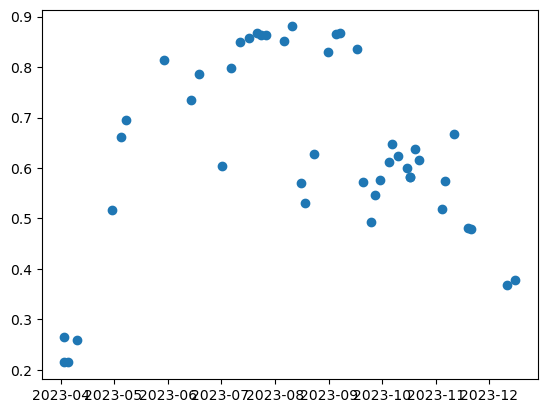

In [53]:
# plot ndvi timeseries for midpoint of field
midpoint_x=s2_cube_clean["x"][round((len(s2_cube_clean["x"]))/2)]
midpoint_y=s2_cube_clean["y"][round((len(s2_cube_clean["y"]))/2)]

# plt.scs2_cube_clean.NDVI.sel(x=midpoint_x,y=midpoint_y).plot()
plt.scatter(x=s2_cube_clean.time,y=s2_cube_clean.NDVI.sel(x=midpoint_x,y=midpoint_y))

## Clean-up

If you run this notebook in your own AWS account, to avoid incurring costs, we recommend to remove all data files created by the pipeline and stored on the S3. 

If you're in an AWS-led workshop, you don't need to perform any clean-up.

In [55]:
print(f'''\033[91m
*********************************************************************
The following line is going to delete ALL files from this S3 url:
{s3_url}/
*********************************************************************\033[0m
''')


*********************************************************************
The following line is going to delete ALL files from this S3 url:
s3://sagemaker-us-east-1-906545278380/processing/geospatial-data-cube/
*********************************************************************



In [ ]:
# Uncomment this line if you really want to delete all data files
# !aws s3 rm {s3_url} --recursive

---